# Modelling the effects of alignment, anchoring and rounding in the task performance of estimation in part-to-whole charts


In [1]:
library(ggplot2)
library(dplyr)
library(ggdist)
library(lme4)
library(ggeffects)
library(patchwork)
library(lmerTest)

lineData <- read.csv("data/alignmentDistsStudy7Line.csv", header=T)
pieData <- read.csv("data/alignmentDistsStudy7Pie.csv", header=T)
lineData$chartType <- "line"
pieData$chartType <- "pie"
data <- rbind(lineData, pieData)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [2]:
data$distToNearest5 <- abs(data$correctResponse - round(data$correctResponse / 5) * 5)
data$distToNearest10 <- abs(data$correctResponse - round(data$correctResponse / 10) * 10)

head(data)

,userID,userSet,responseTimeSeconds,questionOrder,userResponse,questionID,correctResponse,chartType,questionSet,error,absDiff,correct,logError,distToHalfQuarter,distToHorizontalVertical,alignment,distToNearest5,distToNearest10
,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>
1,31,study7Line,13,0,15,2480,15,line,set4,0,0,True,-3.000000,10,0,aligned,0,5
2,31,study7Line,14,1,20,2481,20,line,set1,0,0,True,-3.000000,5,0,aligned,0,0
3,31,study7Line,9,2,25,2482,31,line,set1,-6,6,False,2.614710,6,4,non-aligned,1,1
4,31,study7Line,11,3,15,2483,20,line,set4,-5,5,False,2.357552,5,0,aligned,0,0
5,31,study7Line,11,4,45,2484,44,line,set4,1,1,False,0.169925,6,0,aligned,1,4
6,31,study7Line,21,5,35,2485,45,line,set3,-10,10,False,3.339850,5,7,non-aligned,0,5


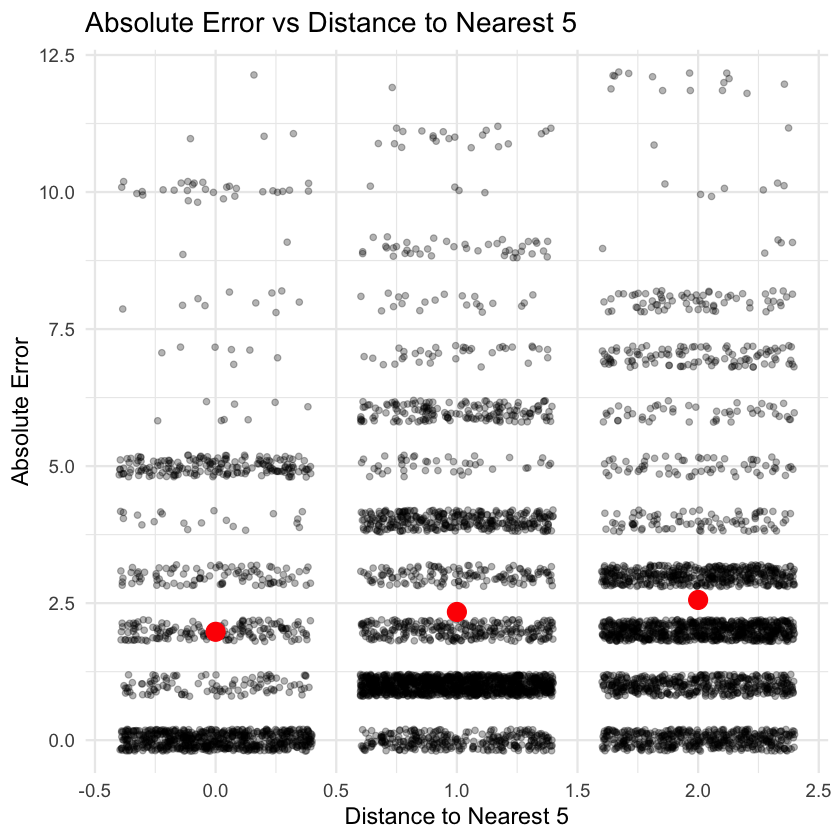

In [112]:
ggplot(data, aes(x = distToNearest5, y = absDiff)) +
  geom_jitter(width = .4, height = 0.2, alpha = 0.3) +
  stat_summary(fun = mean, geom = "point", color = "red", size = 5) +
  labs(
    x = "Distance to Nearest 5",
    y = "Absolute Error",
    title = "Absolute Error vs Distance to Nearest 5"
  ) +
  coord_cartesian(ylim = c(0, 12)) +
  theme_minimal(base_size = 14)

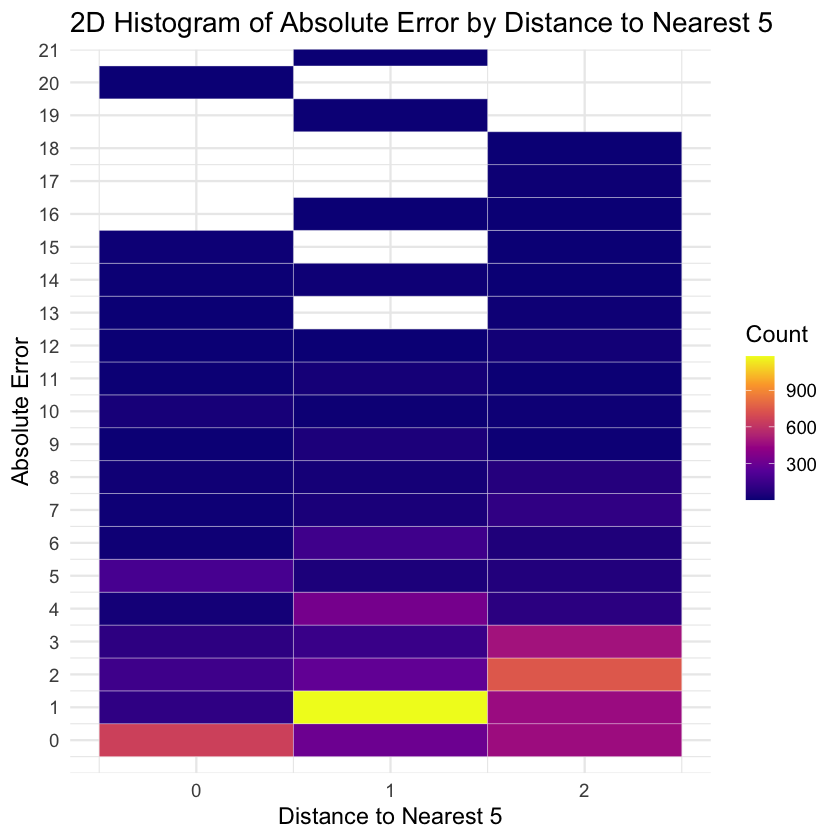

In [113]:
binned <- data %>%
  mutate(
    distToNearest5_bin = as.integer(distToNearest5),
    absDiff_bin = as.integer(absDiff)
  ) %>%
  count(distToNearest5_bin, absDiff_bin, name = "count")

# Plot heatmap
ggplot(binned, aes(x = distToNearest5_bin, y = absDiff_bin, fill = count)) +
  geom_tile(color = "white") +
  scale_fill_viridis_c(option = "C", name = "Count") +
  scale_x_continuous(breaks = unique(binned$distToNearest5_bin)) +
  scale_y_continuous(breaks = unique(binned$absDiff_bin)) +
  labs(
    title = "2D Histogram of Absolute Error by Distance to Nearest 5",
    x = "Distance to Nearest 5",
    y = "Absolute Error"
  ) +
    coord_cartesian(ylim = c(0, 20)) +

  theme_minimal(base_size = 14)

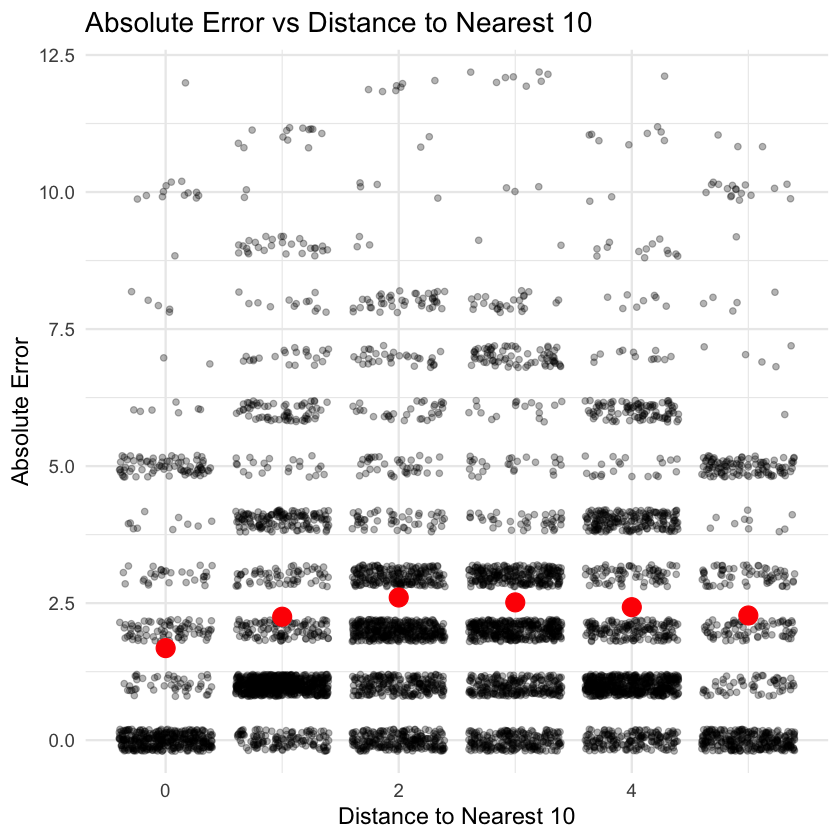

In [114]:
ggplot(data, aes(x = distToNearest10, y = absDiff)) +
  geom_jitter(width = 0.4, height = 0.2, alpha = 0.3) +
  stat_summary(fun = mean, geom = "point", color = "red", size = 5) +
  labs(
    x = "Distance to Nearest 10",
    y = "Absolute Error",
    title = "Absolute Error vs Distance to Nearest 10"
  ) +
  coord_cartesian(ylim = c(0, 12)) +
  theme_minimal(base_size = 14)

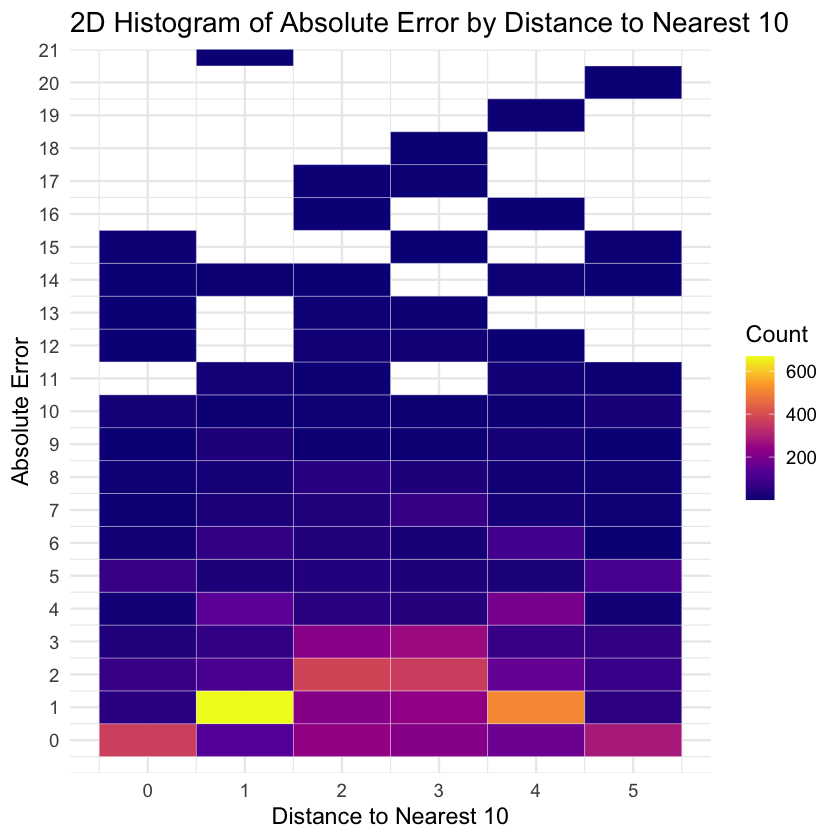

In [109]:
binned <- data %>%
  mutate(
    distToNearest10_bin = as.integer(distToNearest10),
    absDiff_bin = as.integer(absDiff)
  ) %>%
  count(distToNearest10_bin, absDiff_bin, name = "count")

# Plot heatmap
ggplot(binned, aes(x = distToNearest10_bin, y = absDiff_bin, fill = count)) +
  geom_tile(color = "white") +
  scale_fill_viridis_c(option = "C", name = "Count") +
  scale_x_continuous(breaks = unique(binned$distToNearest10_bin)) +
  scale_y_continuous(breaks = unique(binned$absDiff_bin)) +
  labs(
    title = "2D Histogram of Absolute Error by Distance to Nearest 10",
    x = "Distance to Nearest 10",
    y = "Absolute Error"
  ) +
    coord_cartesian(ylim = c(0, 20)) +
  theme_minimal(base_size = 14)

`geom_smooth()` using formula = 'y ~ x'


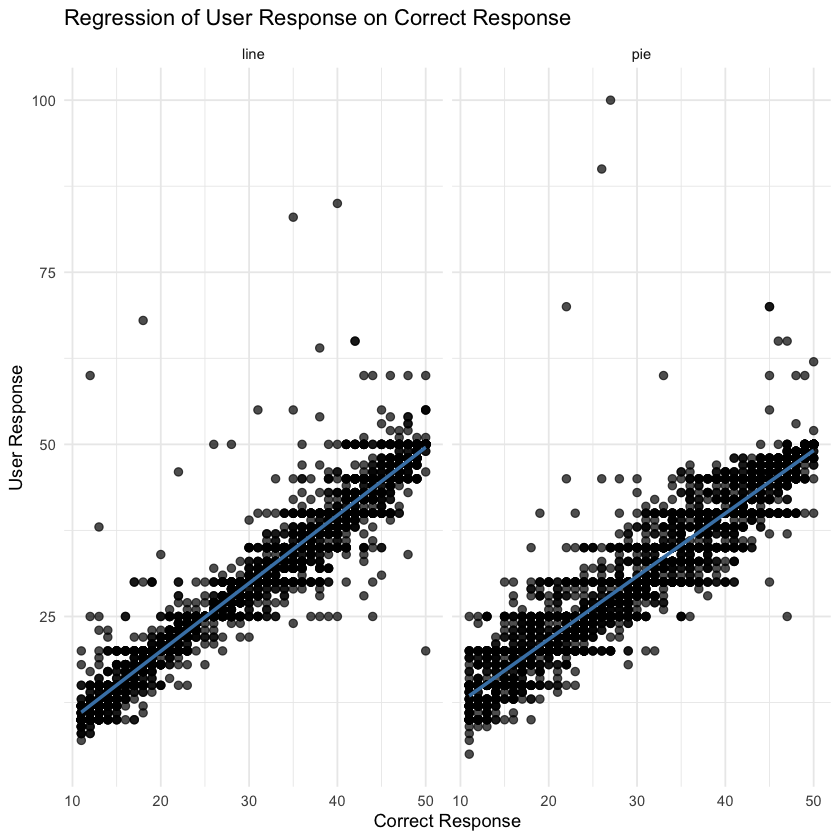

In [ ]:
ggplot(data, aes(x = correctResponse, y = userResponse)) +
  geom_point(size = 2, alpha = 0.7) +
  geom_smooth(method = "lm", se = TRUE, color = "steelblue") +
  facet_wrap(~chartType) +
  theme_minimal() +
  labs(
    title = "Regression of User Response on Correct Response",
    x = "Correct Response",
    y = "User Response"
  )


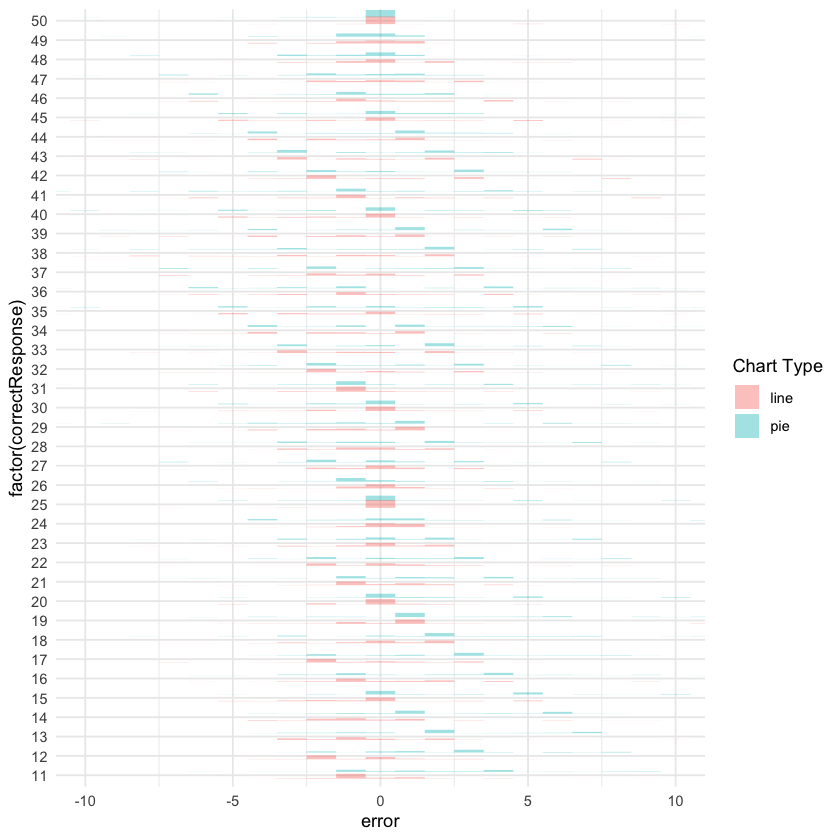

In [ ]:
breaks <- seq(floor(min(data$error))-0.5, ceiling(max(data$error))+0.5, by = 1)

ggplot(data, aes(x = error, y = factor(correctResponse), fill = chartType)) +
  stat_slab(
    aes(thickness = after_stat(pdf)),
    density = "histogram",
    breaks = breaks,
    scale = 0.8,
    alpha = 0.4,
    color = NA,  # remove slab outlines for a cleaner look
    position = position_dodge(width = 0.7)
  ) +
  coord_cartesian(xlim = c(-10, 10)) +
  theme_minimal() +
  labs(
    fill = "Chart Type"
  )

In [125]:
model <- lmer(
    error ~ chartType * (distToHalfQuarter + distToHorizontalVertical + distToNearest5) + (1 | userID),
    data = data
)
summary(model)

ERROR: Error in eval(predvars, data, env): object 'distToNearest5' not found


In [21]:
model_interact <- lmer(
  error ~ chartType * (distToHalfQuarter + distToHorizontalVertical + distToNearest5) + (1 | userID),
  data = data
)
model_no_interact <- lmer(
  error ~ distToHalfQuarter + distToHorizontalVertical + distToNearest5 + chartType + (1 | userID),
  data = data
)

anova(model_no_interact, model_interact)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,-2*log(L),Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model_no_interact,7,35384.17,35431.52,-17685.09,35370.17,NA,NA,NA
model_interact,10,35368.43,35436.07,-17674.21,35348.43,21.74591,3,7.367345e-05


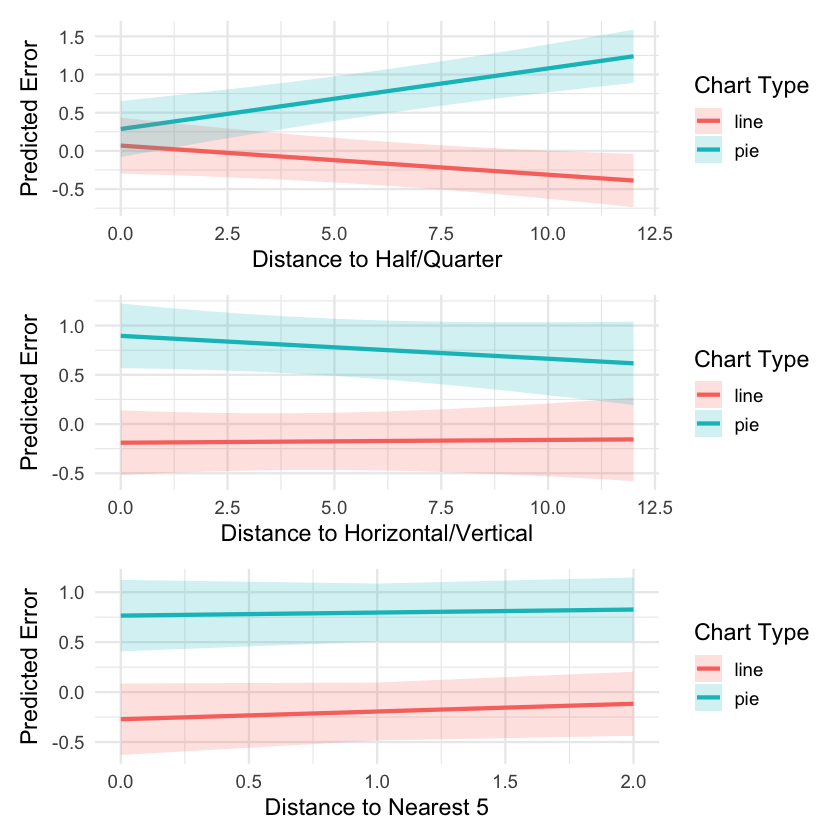

In [ ]:
pred_halfquarter <- ggpredict(model_interact, terms = c("distToHalfQuarter", "chartType"))
pred_horizvert   <- ggpredict(model_interact, terms = c("distToHorizontalVertical", "chartType"))
pred_nearest5    <- ggpredict(model_interact, terms = c("distToNearest5", "chartType"))

# Define a function for plotting
plot_pred <- function(pred_df, xlab_title) {
  ggplot(pred_df, aes(x = x, y = predicted, color = group)) +
    geom_line(size = 1.2) +
    geom_ribbon(aes(ymin = conf.low, ymax = conf.high, fill = group), alpha = 0.2, color = NA) +
    labs(x = xlab_title, y = "Predicted Error", color = "Chart Type", fill = "Chart Type") +
    theme_minimal(base_size = 14)
}

# Make the three plots
plot_halfquarter <- plot_pred(pred_halfquarter, "Distance to Half/Quarter")
plot_horizvert   <- plot_pred(pred_horizvert, "Distance to Horizontal/Vertical")
plot_nearest5    <- plot_pred(pred_nearest5, "Distance to Nearest 5")

plot_halfquarter / plot_horizvert / plot_nearest5

In [51]:
model_interact <- lmer(
  absDiff ~ chartType * (distToHalfQuarter + distToHorizontalVertical + distToNearest5) + (1 | userID),
  data = data
)
model_no_interact <- lmer(
  absDiff ~ distToHalfQuarter + distToHorizontalVertical + distToNearest5 + chartType + (1 | userID),
  data = data
)

anova(model_no_interact, model_interact)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,-2*log(L),Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model_no_interact,7,32524.83,32572.18,-16255.42,32510.83,NA,NA,NA
model_interact,10,32529.13,32596.77,-16254.56,32509.13,1.707794,3,0.6352023


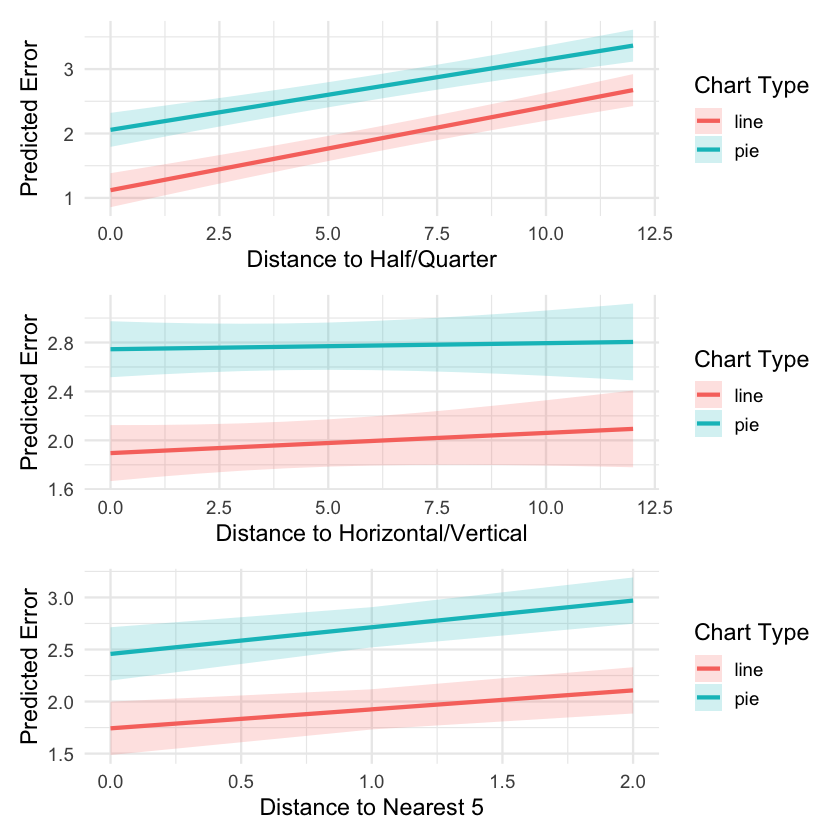

In [53]:
pred_halfquarter <- ggpredict(model_interact, terms = c("distToHalfQuarter", "chartType"))
pred_horizvert   <- ggpredict(model_interact, terms = c("distToHorizontalVertical", "chartType"))
pred_nearest5    <- ggpredict(model_interact, terms = c("distToNearest5", "chartType"))

# Define a function for plotting
plot_pred <- function(pred_df, xlab_title) {
  ggplot(pred_df, aes(x = x, y = predicted, color = group)) +
    geom_line(size = 1.2) +
    geom_ribbon(aes(ymin = conf.low, ymax = conf.high, fill = group), alpha = 0.2, color = NA) +
    labs(x = xlab_title, y = "Predicted Error", color = "Chart Type", fill = "Chart Type") +
    theme_minimal(base_size = 14)
}

# Make the three plots
plot_halfquarter <- plot_pred(pred_halfquarter, "Distance to Half/Quarter")
plot_horizvert   <- plot_pred(pred_horizvert, "Distance to Horizontal/Vertical")
plot_nearest5    <- plot_pred(pred_nearest5, "Distance to Nearest 5")

plot_halfquarter / plot_horizvert / plot_nearest5

In [115]:
model_mixed <- lmer(
  absDiff ~ chartType * (distToNearest5 + distToHalfQuarter * distToHorizontalVertical) +
    (distToNearest5 + distToHalfQuarter + distToHorizontalVertical | userID),
  data = data,
  REML = FALSE  # for comparability and inference on fixed effects
)

summary(model_mixed)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: 
absDiff ~ chartType * (distToNearest5 + distToHalfQuarter * distToHorizontalVertical) +  
    (distToNearest5 + distToHalfQuarter + distToHorizontalVertical |  
        userID)
   Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
  32537.2   32679.3  -16247.6   32495.2      6379 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5619 -0.5142 -0.2436  0.2267 22.6164 

Random effects:
 Groups   Name                     Variance  Std.Dev. Corr             
 userID   (Intercept)              0.0000000 0.00000                   
          distToNearest5           0.1089519 0.33008    NaN            
          distToHalfQuarter        0.0046196 0.06797    NaN -0.56      
          distToHorizontalVertical 0.0006528 0.02555    NaN -0.69  0.99
 Residual                          9.2406342 3.03984                   
Number of obs: 6400, groups:  userID, 40

Fixed effects:
                              

Sorting each group of random effects ('sort.all') is not possible when 'facets = TRUE'.

Sorting each group of random effects ('sort.all') is not possible when 'facets = TRUE'.

Sorting each group of random effects ('sort.all') is not possible when 'facets = TRUE'.

Sorting each group of random effects ('sort.all') is not possible when 'facets = TRUE'.



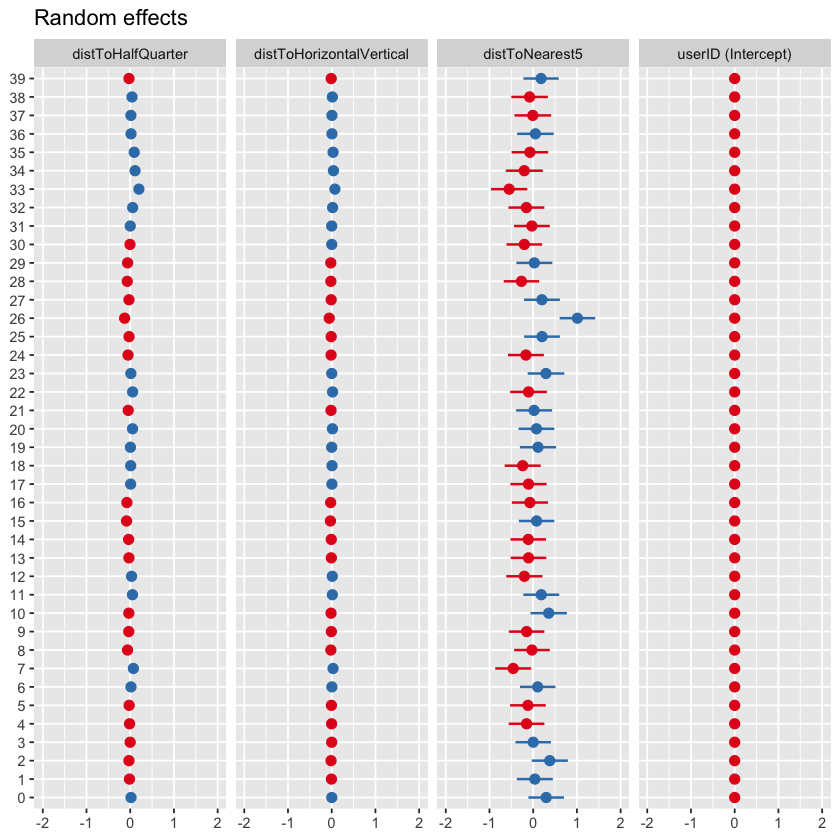

In [119]:
library(sjPlot)
plot_model(model_mixed, type = "re", sort.est = TRUE)


In [ ]:
model_mixed <- lmer(
  absDiff ~ chartType * (distToNearest5 + distToHalfQuarter * distToHorizontalVertical) +
    (distToNearest5 + distToHalfQuarter + distToHorizontalVertical | userID),
  data = data,
  REML = FALSE
)

summary(model_mixed)

boundary (singular) fit: see help('isSingular')

Warning message:
“Model failed to converge with 2 negative eigenvalues: -2.3e+00 -2.0e+03”


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
absDiff ~ chartType * (distToNearest5 + distToHalfQuarter * distToHorizontalVertical) +  
    (distToNearest5 + distToHalfQuarter + distToHorizontalVertical |  
        userID)
   Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
  32537.2   32679.3  -16247.6   32495.2      6379 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5619 -0.5142 -0.2436  0.2267 22.6164 

Random effects:
 Groups   Name                     Variance  Std.Dev. Corr             
 userID   (Intercept)              0.0000000 0.00000                   
          distToNearest5           0.1089519 0.33008    NaN            
          distToHalfQuarter        0.0046196 0.06797    NaN -0.56      
          distToHorizontalVertical 0.0006528 0.02555    NaN -0.69  0.99
 Residual                          9.2406342 3.03984                   
Number of obs: 6400, groups:  userID, 40

F